# AEP Storm Analysis with RAS-Commander

This notebook automates the end-to-end process of analyzing multiple storm events with different Annual Exceedance Probabilities (AEP) in HEC-RAS. It covers:

1. Generating hyetographs from NOAA Atlas 14 precipitation data
2. Creating HEC-RAS plan files for each AEP event
3. Creating unsteady flow files with the generated hyetographs
4. Executing multiple plans in parallel
5. Analyzing and visualizing the results

This automation is particularly useful for analyzing how a drainage system performs under different storm frequencies, from common events (e.g., 2-year) to rare events (e.g., 100-year).

## Setup and Import Libraries

First, we'll import all the necessary libraries and set up our environment.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from pathlib import Path
from datetime import datetime
from IPython import display
import psutil  # For getting system CPU info

# Install ras-commander if not already installed
# Uncomment this line if you need to install the package
# !pip install ras-commander

# Import RAS-Commander modules
from ras_commander import *

In [2]:
RasExamples.extract_project(["Davis"])
# This loads the project in fresh

2025-04-10 05:05:41 - ras_commander.RasExamples - INFO - Found zip file: d:\GitHub\ras-commander\examples\Example_Projects_6_6.zip
2025-04-10 05:05:41 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-04-10 05:05:41 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-04-10 05:05:41 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-04-10 05:05:41 - ras_commander.RasExamples - INFO - Extracting project 'Davis'
2025-04-10 05:05:41 - ras_commander.RasExamples - INFO - Project 'Davis' already exists. Deleting existing folder...
2025-04-10 05:05:41 - ras_commander.RasExamples - INFO - Existing folder for project 'Davis' has been deleted.
2025-04-10 05:05:42 - ras_commander.RasExamples - INFO - Successfully extracted project 'Davis' to d:\GitHub\ras-commander\examples\example_projects\Davis


WindowsPath('d:/GitHub/ras-commander/examples/example_projects/Davis')

## Define Hyetograph Generation Functions

These functions handle reading precipitation frequency data from NOAA Atlas 14 and generating balanced storm hyetographs using the Alternating Block Method.

In [3]:
def parse_duration(duration_str):
    """
    Parses a duration string and converts it to hours.
    Examples: "5-min:" -> 0.0833 hours, "2-hr:" -> 2 hours, "2-day:" -> 48 hours
    """
    match = re.match(r'(\d+)-(\w+):', duration_str.strip())
    if not match:
        raise ValueError(f"Invalid duration format: {duration_str}")
    value, unit = match.groups()
    value = int(value)
    unit = unit.lower()
    if unit in ['min', 'minute', 'minutes']:
        hours = value / 60.0
    elif unit in ['hr', 'hour', 'hours']:
        hours = value
    elif unit in ['day', 'days']:
        hours = value * 24
    else:
        raise ValueError(f"Unknown time unit in duration: {unit}")
    return hours

def read_precipitation_data(csv_file):
    """
    Reads the precipitation frequency CSV and returns a DataFrame
    with durations in hours as the index and ARIs as columns.
    """
    with open(csv_file, 'r') as f:
        lines = f.readlines()

    header_line_idx = None
    header_pattern = re.compile(r'^by duration for ari', re.IGNORECASE)

    # Locate the header line
    for idx, line in enumerate(lines):
        if header_pattern.match(line.strip().lower()):
            header_line_idx = idx
            break

    if header_line_idx is None:
        raise ValueError('Header line for precipitation frequency estimates not found in CSV file.')

    # Extract the ARI headers from the header line
    header_line = lines[header_line_idx].strip()
    headers = [item.strip() for item in header_line.split(',')]
    
    if len(headers) < 2:
        raise ValueError('Insufficient number of ARI columns found in the header line.')

    aris = headers[1:]  # Exclude the first column which is the duration

    # Define the pattern for data lines (e.g., "5-min:", "10-min:", etc.)
    duration_pattern = re.compile(r'^\d+-(min|hr|day):')

    # Initialize lists to store durations and corresponding depths
    durations = []
    depths = {ari: [] for ari in aris}

    # Iterate over the lines following the header to extract data
    for line in lines[header_line_idx + 1:]:
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        if not duration_pattern.match(line):
            break  # Stop if the line does not match the duration pattern
        parts = [part.strip() for part in line.split(',')]
        if len(parts) != len(headers):
            raise ValueError(f"Data row does not match header columns: {line}")
        duration_str = parts[0]
        try:
            duration_hours = parse_duration(duration_str)
        except ValueError as ve:
            print(f"Skipping line due to error: {ve}")
            continue  # Skip lines with invalid duration formats
        durations.append(duration_hours)
        for ari, depth_str in zip(aris, parts[1:]):
            try:
                depth = float(depth_str)
            except ValueError:
                depth = np.nan  # Assign NaN for invalid depth values
            depths[ari].append(depth)

    # Create the DataFrame
    df = pd.DataFrame(depths, index=durations)
    df.index.name = 'Duration_hours'

    # Drop any rows with NaN values
    df = df.dropna()

    return df

def interpolate_depths(df, total_duration):
    """
    Interpolates precipitation depths for each ARI on a log-log scale
    for each hour up to the total storm duration.
    """
    T = total_duration
    t_hours = np.arange(1, T+1)
    D = {}
    for ari in df.columns:
        durations = df.index.values
        depths = df[ari].values
        # Ensure all depths are positive
        if np.any(depths <= 0):
            raise ValueError(f"Non-positive depth value in ARI {ari}")
        # Log-log interpolation
        log_durations = np.log(durations)
        log_depths = np.log(depths)
        log_t = np.log(t_hours)
        log_D_t = np.interp(log_t, log_durations, log_depths)
        D_t = np.exp(log_D_t)
        D[ari] = D_t
    return D

def compute_incremental_depths(D, total_duration):
    """
    Computes incremental precipitation depths for each hour.
    I(t) = D(t) - D(t-1), with D(0) = 0.
    """
    incremental_depths = {}
    for ari, D_t in D.items():
        I_t = np.empty(total_duration)
        I_t[0] = D_t[0]  # I(1) = D(1) - D(0) = D(1)
        I_t[1:] = D_t[1:] - D_t[:-1]
        incremental_depths[ari] = I_t
    return incremental_depths

def assign_alternating_block(sorted_depths, max_depth, central_index, T):
    """
    Assigns incremental depths to the hyetograph using the Alternating Block Method.
    """
    hyetograph = [0.0] * T
    hyetograph[central_index] = max_depth
    remaining_depths = sorted_depths.copy()
    remaining_depths.remove(max_depth)
    left = central_index - 1
    right = central_index + 1
    toggle = True  # Start assigning to the right
    for depth in remaining_depths:
        if toggle and right < T:
            hyetograph[right] = depth
            right += 1
        elif not toggle and left >= 0:
            hyetograph[left] = depth
            left -= 1
        elif right < T:
            hyetograph[right] = depth
            right += 1
        elif left >= 0:
            hyetograph[left] = depth
            left -= 1
        else:
            print("Warning: Not all incremental depths assigned.")
            break
        toggle = not toggle
    return hyetograph

def generate_hyetograph(incremental_depths, position_percent, T):
    """
    Generates the hyetograph for a given ARI using the Alternating Block Method.
    """
    max_depth = np.max(incremental_depths)
    incremental_depths_list = incremental_depths.tolist()
    central_index = int(round(T * position_percent / 100)) - 1
    central_index = max(0, min(central_index, T - 1))
    sorted_depths = sorted(incremental_depths_list, reverse=True)
    hyetograph = assign_alternating_block(sorted_depths, max_depth, central_index, T)
    return hyetograph

def save_hyetograph(hyetograph, ari, output_dir, position_percent, total_duration):
    """
    Saves the hyetograph to a CSV file.
    """
    df = pd.DataFrame({
        'Time_hour': np.arange(1, total_duration + 1),
        'Precipitation_in': hyetograph
    })
    filename = f'hyetograph_ARI_{ari}_years_pos{position_percent}pct_{total_duration}hr.csv'
    output_file = os.path.join(output_dir, filename)
    df.to_csv(output_file, index=False)
    print(f"Hyetograph for ARI {ari} years saved to {output_file}")
    return output_file

def plot_multiple_hyetographs(aris, position_percent, total_duration, output_dir='hyetographs'):
    """
    Plots multiple hyetographs for specified ARIs on the same figure for comparison.
    """
    plt.figure(figsize=(14, 7))
    
    for ari in aris:
        # Ensure ARI is a string for consistent filename formatting
        ari_str = str(ari)
        
        # Construct the filename based on the naming convention
        filename = f'hyetograph_ARI_{ari_str}_years_pos{position_percent}pct_{total_duration}hr.csv'
        filepath = os.path.join(output_dir, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"Warning: File '{filename}' does not exist in the directory '{output_dir}'. Skipping this ARI.")
            continue
        
        # Read the hyetograph data
        try:
            hyetograph_df = pd.read_csv(filepath)
            print(f"Successfully read the hyetograph data from '{filename}'.")
        except Exception as e:
            print(f"Error reading the hyetograph CSV file '{filename}': {e}")
            continue
        
        # Plot the hyetograph
        plt.bar(hyetograph_df['Time_hour'], hyetograph_df['Precipitation_in'], 
                width=0.8, edgecolor='black', alpha=0.5, label=f'ARI {ari_str} years')
    
    # Customize the plot
    plt.xlabel('Time (Hour)', fontsize=14)
    plt.ylabel('Incremental Precipitation (inches)', fontsize=14)
    plt.title(f'Comparison of Hyetographs for ARIs {aris}\nPosition: {position_percent}% | Duration: {total_duration} Hours', fontsize=16)
    plt.legend()
    plt.xticks(range(1, total_duration + 1, max(1, total_duration // 24)))  # Adjust x-ticks based on duration
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Generate AEP Hydrographs

This cell orchestrates the entire AEP analysis process, generating hyetographs

Output directory is set to: hyetographs

Step 1: Generating hyetographs for each AEP event...
Successfully read the input CSV file.

Precipitation Frequency Data from Atlas 14:


,1,2,5,10,25,50,100,200,500,1000
Duration_hours,,,,,,,,,,
0.083333,0.112,0.137,0.174,0.207,0.257,0.299,0.347,0.400,0.479,0.548
0.166667,0.161,0.197,0.250,0.297,0.368,0.429,0.497,0.573,0.687,0.785
0.250000,0.194,0.238,0.302,0.359,0.446,0.519,0.601,0.693,0.830,0.949
0.500000,0.297,0.364,0.461,0.548,0.680,0.792,0.917,1.060,1.270,1.450
1.000000,0.387,0.474,0.601,0.714,0.886,1.030,1.200,1.380,1.650,1.890


Successfully interpolated precipitation depths.
Array D with interpolated depths


{'1': array([0.387     , 0.565     , 0.698     , 0.81032881, 0.9097637 ,
        1.        , 1.06725241, 1.12915421, 1.18672896, 1.24071452,
        1.291663  , 1.34      , 1.38376504, 1.42555845, 1.465601  ,
        1.50407587, 1.54113699, 1.57691513, 1.61152246, 1.64505605,
        1.67760052, 1.70923013, 1.74001053, 1.77      ]),
 '2': array([0.474     , 0.696     , 0.861     , 1.00173485, 1.12655438,
        1.24      , 1.32663817, 1.40656557, 1.48105431, 1.55102324,
        1.61716121, 1.68      , 1.7358511 , 1.78921515, 1.84036945,
        1.88954422, 1.93693302, 1.98270036, 2.0269874 , 2.06991634,
        2.11159376, 2.15211324, 2.19155749, 2.23      ]),
 '5': array([0.601     , 0.88      , 1.09      , 1.26823227, 1.42631602,
        1.57      , 1.68020468, 1.78190194, 1.8767026 , 1.96577052,
        2.04997837, 2.13      , 2.20194862, 2.27072756, 2.33668889,
        2.40012502, 2.46128192, 2.52036871, 2.57756493, 2.63302604,
        2.68688765, 2.73926892, 2.79027516, 2.84     

Successfully computed incremental depths.
Array inc_depths Contents 


{'1': array([0.387     , 0.178     , 0.133     , 0.11232881, 0.09943489,
        0.0902363 , 0.06725241, 0.0619018 , 0.05757475, 0.05398556,
        0.05094849, 0.048337  , 0.04376504, 0.04179342, 0.04004255,
        0.03847487, 0.03706112, 0.03577814, 0.03460734, 0.03353359,
        0.03254446, 0.03162962, 0.0307804 , 0.02998947]),
 '2': array([0.474     , 0.222     , 0.165     , 0.14073485, 0.12481953,
        0.11344562, 0.08663817, 0.07992741, 0.07448873, 0.06996894,
        0.06613797, 0.06283879, 0.0558511 , 0.05336405, 0.0511543 ,
        0.04917477, 0.0473888 , 0.04576733, 0.04428704, 0.04292894,
        0.04167742, 0.04051948, 0.03944425, 0.03844251]),
 '5': array([0.601     , 0.279     , 0.21      , 0.17823227, 0.15808375,
        0.14368398, 0.11020468, 0.10169726, 0.09480066, 0.08906792,
        0.08420785, 0.08002163, 0.07194862, 0.06877894, 0.06596132,
        0.06343613, 0.0611569 , 0.05908679, 0.05719622, 0.0554611 ,
        0.05386161, 0.05238127, 0.05100624, 0.0497248

Hyetograph for ARI 2 years saved to hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv
Hyetograph for ARI 5 years saved to hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv
Hyetograph for ARI 10 years saved to hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv
Hyetograph for ARI 25 years saved to hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv
Hyetograph for ARI 50 years saved to hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv
Hyetograph for ARI 100 years saved to hyetographs\hyetograph_ARI_100_years_pos50pct_24hr.csv

All hyetographs have been generated and saved.
Successfully read the hyetograph data from 'hyetograph_ARI_2_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI_5_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI_10_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI_25_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI

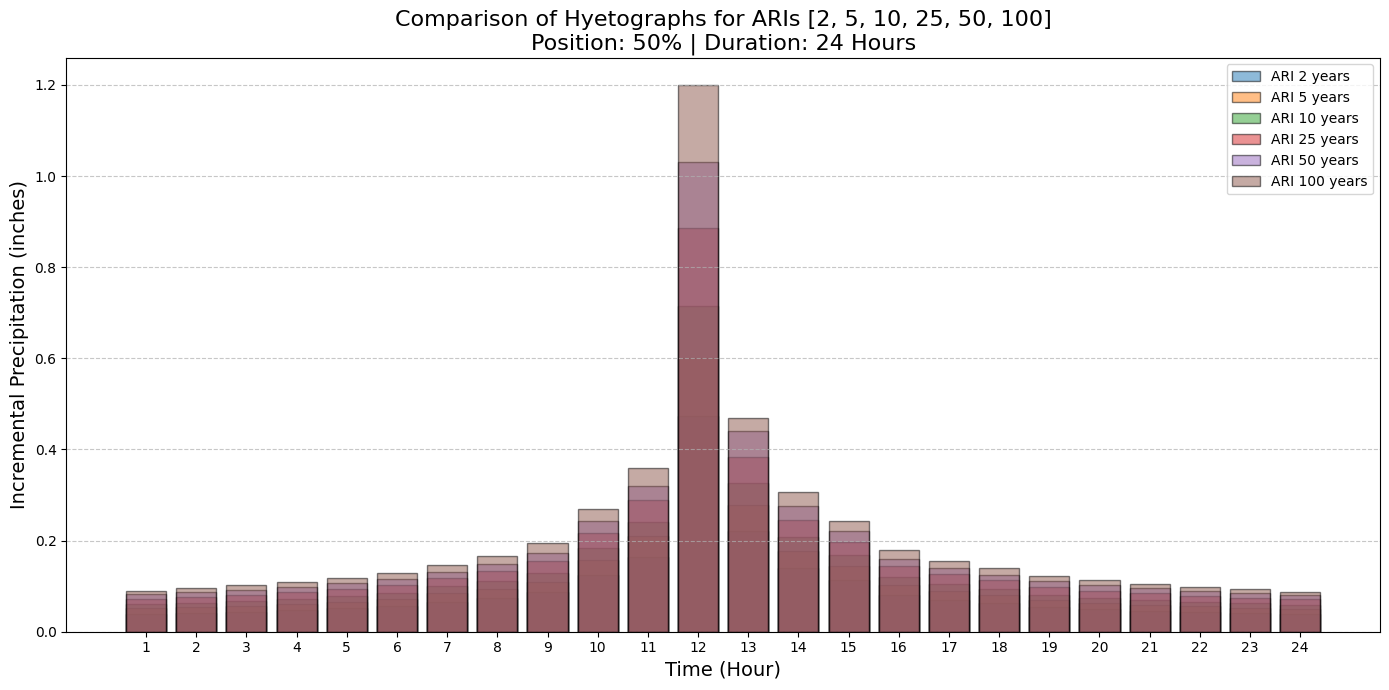

In [4]:

"""
Main function to run the entire AEP analysis process.
"""
# Set the paths and parameters
input_csv = 'data/PF_Depth_English_PDS_DavisCA.csv'  # Path to NOAA Atlas 14 data
output_dir = 'hyetographs'  # Directory for saving hyetographs
position_percent = 50  # Position percentage for the maximum incremental depth block
total_duration = 24  # Storm duration in hours
base_plan = "02"  # Base plan to clone

# Set the AEP events (return periods in years)
aep_events = [2, 5, 10, 25, 50, 100]

# Ensure the output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(f"Output directory is set to: {output_dir}")

#-------------------------------------------------------------------------
# Step 1: Generate hyetographs for each AEP event
#-------------------------------------------------------------------------
print("\nStep 1: Generating hyetographs for each AEP event...")

try:
    # Read precipitation data
    df = read_precipitation_data(input_csv)
    print("Successfully read the input CSV file.")
    
    # Display the first few rows of the DataFrame to verify
    print("\nPrecipitation Frequency Data from Atlas 14:")
    display.display(df.head())
    
    # Interpolate depths
    D = interpolate_depths(df, total_duration)
    print("Successfully interpolated precipitation depths.")

    print("Array D with interpolated depths")
    display.display(D)
    
    # Compute incremental depths
    inc_depths = compute_incremental_depths(D, total_duration)
    print("Successfully computed incremental depths.")
    
    # Show Incremental Depths
    print("Array inc_depths Contents ")
    display.display(inc_depths)

    # Generate and save hyetographs for each AEP
    hyetograph_files = {}
    for ari in aep_events:
        ari_str = str(ari)
        if ari_str in inc_depths:
            hyetograph = generate_hyetograph(inc_depths[ari_str], position_percent, total_duration)
            file_path = save_hyetograph(hyetograph, ari_str, output_dir, position_percent, total_duration)
            hyetograph_files[ari_str] = file_path
        else:
            print(f"Warning: ARI {ari_str} not found in the data. Skipping.")
    
    print("\nAll hyetographs have been generated and saved.")
    
    # Plot the hyetographs for comparison
    plot_multiple_hyetographs(aep_events, position_percent, total_duration, output_dir)
    
except Exception as e:
    print(f"Error generating hyetographs: {e}")
    raise

In [5]:
#-------------------------------------------------------------------------
# Initialize the HEC-RAS project
#-------------------------------------------------------------------------
print("\nStep 2: Initializing the HEC-RAS ras...")

# Define the path to the Davis project
current_dir = Path.cwd()
pipes_ex_path = current_dir / "example_projects" / "Davis"

# Check if the project exists
if not pipes_ex_path.exists():
    # Extract the project if needed
    RasExamples.extract_project(["Davis"])

# Initialize the RAS project
init_ras_project(pipes_ex_path, "6.6")
print(f"Initialized HEC-RAS project: {ras.project_name}")

# Display the existing plans
print("\nExisting plans in the project:")
display.display(ras.plan_df)

2025-04-10 05:05:43 - ras_commander.RasPrj - INFO - Initializing global 'ras' object via init_ras_project function.
2025-04-10 05:05:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:43 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: d:\GitHub\ras-commander\examples\example_projects\Davis



Step 2: Initializing the HEC-RAS ras...
Initialized HEC-RAS project: DavisStormSystem

Existing plans in the project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,d:\GitHub\ras-commander\examples\example_proje...,01,d:\GitHub\ras-commander\examples\example_proje...,d:\GitHub\ras-commander\examples\example_proje...


In [6]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,d:\GitHub\ras-commander\examples\example_proje...,01,d:\GitHub\ras-commander\examples\example_proje...,d:\GitHub\ras-commander\examples\example_proje...


In [7]:
ras.unsteady_df

,unsteady_number,full_path,geometry_number,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,01,d:\GitHub\ras-commander\examples\example_proje...,None,Full System Rain w/ Pump,6.60,0,Disable,No Wind Forces,Constant,None,-1,in/hr,DSS


In [8]:
print(ras.boundaries_df)

  unsteady_number  boundary_condition_number river_reach_name river_station  \
0              01                          1                                  
1              01                          2                                  

  storage_area_name pump_station_name       bc_type hydrograph_type  \
0                                      Normal Depth            None   
1                                           Unknown            None   

   hydrograph_num_values Interval  ...                Flow Title  \
0                      0      NaN  ...  Full System Rain w/ Pump   
1                      0    1HOUR  ...  Full System Rain w/ Pump   

  Program Version Use Restart Precipitation Mode       Wind Mode  \
0            6.60           0            Disable  No Wind Forces   
1            6.60           0            Disable  No Wind Forces   

  Met BC=Precipitation|Mode Met BC=Evapotranspiration|Mode  \
0                  Constant                           None   
1             

In [9]:
# Get the path to unsteady flow file associated with Plan "01"
unsteady_file = RasPlan.get_unsteady_path("01")
print(f"Unsteady flow file path: {unsteady_file}")

Unsteady flow file path: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01


In [10]:
unsteady_file

'd:\\GitHub\\ras-commander\\examples\\example_projects\\Davis\\DavisStormSystem.u01'

In [11]:
# Extract boundary conditions and tables
boundaries_df = RasUnsteady.extract_boundary_and_tables(unsteady_file)
print(f"Extracted {len(boundaries_df)} boundary conditions from the unsteady flow file.")

2025-04-10 05:05:43 - ras_commander.RasUnsteady - INFO - Successfully extracted boundaries and tables from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01


Extracted 2 boundary conditions from the unsteady flow file.


In [12]:
boundaries_df

,DSS File,Tables,River Name,Reach Name,River Station,Downstream River Station,Storage Area Connection,Storage Area Name,Pump Station Name,Blank 1,Blank 2
0,,{},,,,,,DS Channel,,DS Normal,
1,,{},,,,,,area2,,,


In [13]:
# Display the contents of Unsteady File
with open(unsteady_file, 'r') as f:
    unsteady_contents = f.read()
print(f"Contents of unsteady flow file {unsteady_file}:")
print("-" * 80)
print(unsteady_contents)
print("-" * 80)

Contents of unsteady flow file d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01:
--------------------------------------------------------------------------------
Flow Title=Full System Rain w/ Pump
Program Version=6.60
Use Restart= 0 
Boundary Location=                ,                ,        ,        ,                ,DS Channel      ,                ,DS Normal                       ,                                
Friction Slope=0.003,0
Boundary Location=                ,                ,        ,        ,                ,area2           ,                ,                                ,                                
Interval=1HOUR
Precipitation Hydrograph= 21 
      .1      .1      .1     .25     .25     .25     .25       0       0       0
       0       0       0       0       0       0       0       0       0       0
       0
DSS Path=
Use DSS=False
Use Fixed Start Time=False
Fixed Start Date/Time=,
Is Critical Boundary=False
Critical Boundary Flow

### To implement AEP event hydrographs, we will edit the Precipitation Hydrograph table
We will need to edit both the number of values, as well as replacing the existing fixed-width table.  

#### Define HEC-RAS Plan and Unsteady Flow File Functions

These functions handle creating HEC-RAS plan files and unsteady flow files for each AEP event. They apply the generated hyetographs to the boundary conditions.

In [14]:
def create_plan_for_aep(base_plan, aep_years, duration_hours, hyetograph_file, project):
    """
    Creates a new plan for a specific AEP event.
    """
    # Create plan name and short ID
    plan_name = f"{aep_years}YR-{duration_hours}HR"
    
    print(f"Creating new plan '{plan_name}'...")
    
    # Clone the base plan
    new_plan_number = RasPlan.clone_plan(base_plan, new_plan_shortid=plan_name, ras_object=project)
    print(f"Created new plan: {new_plan_number}")
    
    # Clone the unsteady flow file from the base plan
    base_unsteady = None
    for _, row in project.plan_df.iterrows():
        if row['plan_number'] == base_plan:
            base_unsteady = row.get('unsteady_number', None)
            
    if base_unsteady is None:
        raise ValueError(f"Could not find unsteady flow file for base plan {base_plan}")

    
    new_unsteady_number = RasPlan.clone_unsteady(base_unsteady, ras_object=project)
    print(f"Created new unsteady flow file: {new_unsteady_number}")
    
    # Update the unsteady flow file with the hyetograph data
    unsteady_file_path = RasPlan.get_unsteady_path(new_unsteady_number, ras_object=project)
    
    
    # Update the flow title to reflect the AEP event
    new_title = f"{aep_years}YR-{duration_hours}HR Storm"
    RasUnsteady.update_flow_title(unsteady_file_path, new_title, ras_object=project)
    print(f"Updated unsteady flow title to: {new_title}")
    
    # Modify the unsteady flow file with the hyetograph data
    success = modify_unsteady_flow_with_hyetograph(unsteady_file_path, hyetograph_file, project)
    if success:
        print(f"Successfully applied hyetograph data from {hyetograph_file} to unsteady flow file")
    else:
        print(f"Warning: Failed to apply hyetograph data. Unsteady flow file may need manual modification.")
    
    # Assign the unsteady flow file to the plan
    RasPlan.set_unsteady(new_plan_number, new_unsteady_number, ras_object=project)
    print(f"Assigned unsteady flow file {new_unsteady_number} to plan {new_plan_number}")
    '''
    # Update the plan description
    description = f"AEP {aep_years}-year, {duration_hours}-hour storm\n"
    description += f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
    description += f"Based on plan {base_plan}\n"
    description += f"Hyetograph from: {os.path.basename(hyetograph_file)}"
    
    RasPlan.update_plan_description(new_plan_number, description, ras_object=project)
    print(f"Updated plan description for plan {new_plan_number}")
    
    return new_plan_number, new_unsteady_number
    '''

In [15]:
def modify_unsteady_flow_with_hyetograph(unsteady_file_path, hyetograph_file, project):
    """
    Modifies an unsteady flow file to incorporate hyetograph data as precipitation.
    
    Parameters:
    - unsteady_file_path: Path to the unsteady flow file
    - hyetograph_file: Path to the hyetograph data CSV
    - project: RAS project object
    
    Returns:
    - Boolean indicating success
    """
    try:
        # Read the hyetograph data
        hyetograph_df = pd.read_csv(hyetograph_file)
        print(f"Loaded hyetograph from {hyetograph_file} with {len(hyetograph_df)} values")
        
        # Read the unsteady flow file
        with open(unsteady_file_path, 'r') as file:
            lines = file.readlines()
        
        # Find the sections that need to be modified
        precip_hydrograph_index = None
        
        for i, line in enumerate(lines):
            if line.startswith("Precipitation Hydrograph="):
                precip_hydrograph_index = i
                break
        
        if precip_hydrograph_index is None:
            print("Cannot find Precipitation Hydrograph section in unsteady file.")
            return False
        
        # Get the time interval from the hyetograph
        time_interval = "1HOUR"  # Default
        if "Time_hour" in hyetograph_df.columns and len(hyetograph_df) > 1:
            hour_diff = hyetograph_df["Time_hour"].iloc[1] - hyetograph_df["Time_hour"].iloc[0]
            time_interval = f"{int(hour_diff)}HOUR" if hour_diff >= 1 else f"{int(hour_diff*60)}MIN"
        
        # Format the precipitation values for the hydrograph
        precipitation_values = hyetograph_df["Precipitation_in"].values
        
        # Create the Precipitation Hydrograph line
        precip_line = f"Precipitation Hydrograph= {len(precipitation_values)} \n"
        
        # Format the values in groups of 10 per line
        value_lines = []
        for i in range(0, len(precipitation_values), 10):
            row_values = precipitation_values[i:i+10]
            row_line = "".join([f"{value:8.2f}" for value in row_values]) + "\n"
            value_lines.append(row_line)
            
        # Remove old hydrograph data - find end of current hydrograph
        current_line = precip_hydrograph_index + 1
        while current_line < len(lines) and not any(lines[current_line].startswith(prefix) for prefix in ["DSS Path=", "Use DSS=", "Use Fixed Start Time="]):
            current_line += 1
            
        # Replace the hydrograph section
        lines[precip_hydrograph_index:current_line] = [precip_line] + value_lines
            
        # Write the modified file back
        with open(unsteady_file_path, 'w') as file:
            file.writelines(lines)
            
        print(f"Successfully applied hyetograph data from {hyetograph_file} to unsteady flow file.")
        print(f"Added {len(precipitation_values)} precipitation values with interval {time_interval}")
        return True
        
    except Exception as e:
        print(f"Error modifying unsteady flow file: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

In [16]:
#-------------------------------------------------------------------------
# Create new plans for each AEP event
#-------------------------------------------------------------------------
print("\nStep 3: Creating new plans for each AEP event...")

new_plan_numbers = []

for ari in aep_events:
    ari_str = str(ari)
    if ari_str in hyetograph_files:
        try:
            # Create a new plan for this AEP event
            new_plan_number, _ = create_plan_for_aep(
                base_plan=base_plan,
                aep_years=ari_str,
                duration_hours=total_duration,
                hyetograph_file=hyetograph_files[ari_str],
                project=ras
            )
            new_plan_numbers.append(new_plan_number)
        except Exception as e:
            print(f"Error creating plan for AEP {ari_str}: {e}")

# Display the updated plans
print("\nUpdated plans in the project:")
display.display(ras.plan_df)


Step 3: Creating new plans for each AEP event...
Creating new plan '2YR-24HR'...


2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p01
2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - Successfully updated file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p01
2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 01
2025-04-10 05:05:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap


Created new plan: 01


2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u02
2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 02
2025-04-10 05:05:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:43 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '2YR-24HR Storm'
2025-04-10 05:05:43 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u02
2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02 to d:\GitHub\ras-commander\examples\example_projects\Dav

Created new unsteady flow file: 02
Updated unsteady flow title to: 2YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 02 to plan 01
Error creating plan for AEP 2: cannot unpack non-iterable NoneType object
Creating new plan '5YR-24HR'...


2025-04-10 05:05:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u03
2025-04-10 05:05:43 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 03


Created new plan: 03


2025-04-10 05:05:43 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:43 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '5YR-24HR Storm'
2025-04-10 05:05:43 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u03
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p04
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Successfully updated file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p04
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 04


Created new unsteady flow file: 03
Updated unsteady flow title to: 5YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 03 to plan 03
Error creating plan for AEP 5: cannot unpack non-iterable NoneType object
Creating new plan '10YR-24HR'...


2025-04-10 05:05:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u04
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 04
2025-04-10 05:05:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap


Created new plan: 04


2025-04-10 05:05:44 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-24HR Storm'
2025-04-10 05:05:44 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u04
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p05
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Successfully updated file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p05
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 05
2025-04-10 05:05:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:44 - ras_commander.RasUtils - IN

Created new unsteady flow file: 04
Updated unsteady flow title to: 10YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 04 to plan 04
Error creating plan for AEP 10: cannot unpack non-iterable NoneType object
Creating new plan '25YR-24HR'...
Created new plan: 05


2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 05
2025-04-10 05:05:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap


Created new unsteady flow file: 05


2025-04-10 05:05:44 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '25YR-24HR Storm'
2025-04-10 05:05:44 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u05
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p06
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Successfully updated file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p06
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 06
2025-04-10 05:05:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:44 - ras_commander.RasUtils - IN

Updated unsteady flow title to: 25YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 05 to plan 05
Error creating plan for AEP 25: cannot unpack non-iterable NoneType object
Creating new plan '50YR-24HR'...
Created new plan: 06


2025-04-10 05:05:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap


Created new unsteady flow file: 06


2025-04-10 05:05:44 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '50YR-24HR Storm'
2025-04-10 05:05:44 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u06
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - File cloned from d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02 to d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p07
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Successfully updated file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.p07
2025-04-10 05:05:44 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07
2025-04-10 05:05:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.rasmap
2025-04-10 05:05:44 - ras_commander.RasUtils - IN

Updated unsteady flow title to: 50YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 06 to plan 06
Error creating plan for AEP 50: cannot unpack non-iterable NoneType object
Creating new plan '100YR-24HR'...
Created new plan: 07
Created new unsteady flow file: 07
Updated unsteady flow title to: 100YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_100_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_100_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,None,01,None,d:\GitHub\ras-commander\examples\example_proje...
1,01,02,02,Full System ROM with Pump,6.60,2YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,None,02,None,d:\GitHub\ras-commander\examples\example_proje...
2,03,03,02,Full System ROM with Pump,6.60,5YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,None,03,None,d:\GitHub\ras-commander\examples\example_proje...
3,04,04,02,Full System ROM with Pump,6.60,10YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,None,04,None,d:\GitHub\ras-commander\examples\example_proje...
4,05,05,02,Full System ROM with Pump,6.60,25YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,None,05,None,d:\GitHub\ras-commander\examples\example_proje...
5,06,06,02,Full System ROM with Pump,6.60,50YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,None,06,None,d:\GitHub\ras-commander\examples\example_proje...
6,07,07,02,Full System ROM with Pump,6.60,100YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,None,02,None,u07,d:\GitHub\ras-commander\examples\example_proje...,d:\GitHub\ras-commander\examples\example_proje...


In [17]:
# Get the path to unsteady flow file associated with Plan "03"
unsteady_file_rev = RasPlan.get_unsteady_path("03")
print(f"Unsteady flow file path: {unsteady_file_rev}")

Unsteady flow file path: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u03


In [18]:
unsteady_file_rev

'd:\\GitHub\\ras-commander\\examples\\example_projects\\Davis\\DavisStormSystem.u03'

In [19]:
with open(unsteady_file_rev, 'r') as f:
    unsteady_contents_rev = f.read()
print(f"Contents of unsteady flow file for plan 03 ({unsteady_file_rev}):")
print("-" * 80)
print(unsteady_contents_rev)
print("-" * 80)

Contents of unsteady flow file for plan 03 (d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u03):
--------------------------------------------------------------------------------
Flow Title=5YR-24HR Storm
Program Version=6.60
Use Restart= 0 
Boundary Location=                ,                ,        ,        ,                ,DS Channel      ,                ,DS Normal                       ,                                
Friction Slope=0.003,0
Boundary Location=                ,                ,        ,        ,                ,area2           ,                ,                                ,                                
Interval=1HOUR
Precipitation Hydrograph= 24 
    0.05    0.05    0.06    0.06    0.07    0.07    0.08    0.09    0.11    0.16
    0.21    0.60    0.28    0.18    0.14    0.10    0.09    0.08    0.07    0.06
    0.06    0.06    0.05    0.05
DSS Path=
Use DSS=False
Use Fixed Start Time=False
Fixed Start Date/Time=,
Is Critical Boundary=

In [20]:
import difflib

def show_file_diff(file1_path, file2_path, context_lines=3):
    """
    Shows the differences between two files with context.
    
    Parameters:
    - file1_path: Path to the first file
    - file2_path: Path to the second file
    - context_lines: Number of context lines to show around differences
    """
    # Read the file contents
    with open(file1_path, 'r') as file1:
        file1_lines = file1.readlines()
    
    with open(file2_path, 'r') as file2:
        file2_lines = file2.readlines()
    
    # Create a differ object
    differ = difflib.unified_diff(
        file1_lines, 
        file2_lines,
        fromfile=str(file1_path),
        tofile=str(file2_path),
        n=context_lines
    )
    
    # Convert differ output to a string
    diff_text = ''.join(differ)
    
    # If no differences found
    if not diff_text:
        print(f"No differences found between {file1_path} and {file2_path}")
        return
    
    # Print the differences
    print(f"Differences between {file1_path} and {file2_path}:")
    print("-" * 80)
    print(diff_text)
    print("-" * 80)
    
    # Count added, removed, and modified lines
    added = sum(1 for line in diff_text.splitlines() if line.startswith('+') and not line.startswith('+++'))
    removed = sum(1 for line in diff_text.splitlines() if line.startswith('-') and not line.startswith('---'))
    
    print(f"Summary: {added} additions, {removed} removals")

# Show differences between the unsteady flow files
if 'unsteady_file' in locals() and 'unsteady_file_rev' in locals():
    show_file_diff(unsteady_file, unsteady_file_rev)
else:
    print("Error: One or both unsteady flow file variables not defined.")
    print("Please run the cells that define unsteady_file and unsteady_file_rev first.")

Differences between d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01 and d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u03:
--------------------------------------------------------------------------------
--- d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01
+++ d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u03
@@ -1,14 +1,14 @@
-Flow Title=Full System Rain w/ Pump
+Flow Title=5YR-24HR Storm
 Program Version=6.60
 Use Restart= 0 
 Boundary Location=                ,                ,        ,        ,                ,DS Channel      ,                ,DS Normal                       ,                                
 Friction Slope=0.003,0
 Boundary Location=                ,                ,        ,        ,                ,area2           ,                ,                                ,                                
 Interval=1HOUR
-Precipitation Hydrograph= 21 
-      .1 

#### Define Parallel Execution and Results Analysis Functions

These functions manage parallel plan execution with resource optimization and extract, analyze, and visualize the results.

In [21]:
def execute_plans_in_parallel(plan_numbers, project, max_workers=None, cores_per_worker=2):
    """
    Executes multiple plans in parallel.
    """
    # Calculate optimal number of workers if not provided
    if max_workers is None:
        physical_cores = psutil.cpu_count(logical=False)  # Physical cores only
        max_workers = max(1, physical_cores // cores_per_worker)
    
    print(f"Executing {len(plan_numbers)} plans in parallel with {max_workers} workers, " + 
          f"each using {cores_per_worker} cores...")
    
    # Create compute folder
    compute_folder = Path(project.project_folder) / "compute_aep_parallel"
    compute_folder.mkdir(parents=True, exist_ok=True)
    
    # Execute plans in parallel
    start_time = time.time()
    
    results = RasCmdr.compute_parallel(
        plan_number=plan_numbers,
        max_workers=max_workers,
        num_cores=cores_per_worker,
        dest_folder=compute_folder,
        clear_geompre=True,
        overwrite_dest=True,
        ras_object=project
    )
    
    end_time = time.time()
    total_duration = end_time - start_time
    
    print(f"Parallel execution completed in {total_duration:.2f} seconds")
    
    # Create a DataFrame from the execution results
    results_df = pd.DataFrame([
        {"Plan": plan, "Success": success}
        for plan, success in results.items()
    ])
    
    # Sort by plan number
    results_df = results_df.sort_values("Plan")
    
    print("\nExecution Results:")
    display.display(results_df)
    
    return results, compute_folder

In [22]:
# Get the path to unsteady flow file associated with Plan "01"
unsteady_file = RasPlan.get_unsteady_path("01")
print(f"Unsteady flow file path: {unsteady_file}")

Unsteady flow file path: d:\GitHub\ras-commander\examples\example_projects\Davis\DavisStormSystem.u01


In [23]:
#-------------------------------------------------------------------------
# Execute all plans in parallel
#-------------------------------------------------------------------------

In [24]:
# Set computation parameters for better performance
for plan_number in new_plan_numbers:
    RasPlan.set_num_cores(plan_number, 2, ras_object=ras)
    RasPlan.update_plan_intervals(
        plan_number,
        computation_interval="15MIN",
        output_interval="30MIN",
        mapping_interval="1HOUR",
        ras_object=ras
    )
    print(f"Updated computation settings for plan {plan_number}")

# Execute plans in parallel
results, compute_folder = execute_plans_in_parallel(
    plan_numbers=new_plan_numbers,
    project=ras
)

2025-04-10 05:05:44 - ras_commander.RasCmdr - INFO - Destination folder 'd:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel' exists. Overwriting as per overwrite_dest=True.
2025-04-10 05:05:44 - ras_commander.RasCmdr - INFO - Copied project folder to destination: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel
2025-04-10 05:05:44 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 1 based on the number of plans: 7
2025-04-10 05:05:44 - ras_commander.RasCmdr - INFO - Created worker folder: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel [Worker 1]


Executing 0 plans in parallel with 1 workers, each using 2 cores...


2025-04-10 05:05:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel [Worker 1]\DavisStormSystem.rasmap
2025-04-10 05:05:45 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel [Worker 1]\DavisStormSystem.rasmap
2025-04-10 05:05:45 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-04-10 05:05:45 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel [Worker 1]
2025-04-10 05:05:45 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel [Worker 1]
2025-04-10 05:05:45 - ras_commander.RasGeo - INFO - Clearing geometry preprocessor file for single plan: d:\GitHub\ras-com

Parallel execution completed in 489.36 seconds

Execution Results:


,Plan,Success
1,01,True
0,02,True
2,03,True
3,04,True
4,05,True
5,06,True
6,07,True


print("\nStep 4: Executing all plans in parallel...")

results, compute_folder = execute_plans_in_parallel(
    plan_numbers=new_plan_numbers,
    project=ras
)

In [25]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,d:\GitHub\ras-commander\examples\example_proje...,02,None,01,None,d:\GitHub\ras-commander\examples\example_proje...
1,01,02,02,Full System ROM with Pump,6.60,2YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,d:\GitHub\ras-commander\examples\example_proje...,02,None,02,None,d:\GitHub\ras-commander\examples\example_proje...
2,03,03,02,Full System ROM with Pump,6.60,5YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,d:\GitHub\ras-commander\examples\example_proje...,02,None,03,None,d:\GitHub\ras-commander\examples\example_proje...
3,04,04,02,Full System ROM with Pump,6.60,10YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,d:\GitHub\ras-commander\examples\example_proje...,02,None,04,None,d:\GitHub\ras-commander\examples\example_proje...
4,05,05,02,Full System ROM with Pump,6.60,25YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,d:\GitHub\ras-commander\examples\example_proje...,02,None,05,None,d:\GitHub\ras-commander\examples\example_proje...
5,06,06,02,Full System ROM with Pump,6.60,50YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,d:\GitHub\ras-commander\examples\example_proje...,02,None,06,None,d:\GitHub\ras-commander\examples\example_proje...
6,07,07,02,Full System ROM with Pump,6.60,100YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,dss,1,PARDISO (Direct),area2,d:\GitHub\ras-commander\examples\example_proje...,02,None,07,None,d:\GitHub\ras-commander\examples\example_proje...


In [26]:
runtime_df = HdfResultsPlan.get_runtime_data("02")

2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p02.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p02.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Plan Name: Full System ROM with Pump
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0


In [27]:
runtime_df

,Plan Name,File Name,Simulation Start Time,Simulation End Time,Simulation Duration (s),Simulation Time (hr),Completing Geometry (hr),Preprocessing Geometry (hr),Completing Event Conditions (hr),Unsteady Flow Computations (hr),Complete Process (hr),Unsteady Flow Speed (hr/hr),Complete Process Speed (hr/hr)
0,Full System ROM with Pump,DavisStormSystem.p02.hdf,2000-01-10 12:00:00,2000-01-12,129600.0,36.0,N/A,0.000082,N/A,0.019058,0.020725,1888.937473,1737.032569


In [28]:
pipe_flow_ds = HdfPipe.get_pipe_network_timeseries("02", variable="Pipes/Pipe Flow DS")


2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p02.hdf


In [29]:
pipe_flow_ds 

<xarray.DataArray 'Pipes/Pipe Flow DS' (time: 217, location: 132)> Size: 115kB
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       ...,
       [ 9.8975849e-01,  2.3587736e-01,  8.6188068e+00, ...,
         8.9480855e-05,  8.9233086e-05,  9.9323086e-05],
       [ 5.8148694e-01,  2.3296316e-01,  3.0015060e-01, ...,
         8.8552792e-05,  8.8308771e-05,  9.8268960e-05],
       [ 5.7388496e-01,  2.3010144e-01,  2.9207700e-01, ...,
         8.7642940e-05,  8.7402928e-05,  9.7233606e-05]],
      shape=(217, 132), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 125 126 127 128 129 130 131
Attributes:
    units:     ft^3/s
    variable:  Pipes/Pipe Flow DS

In [30]:
node_ws = HdfPipe.get_pipe_network_timeseries("02", variable="Nodes/Water Surface")

2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p02.hdf


In [31]:
node_ws

<xarray.DataArray 'Nodes/Water Surface' (time: 217, location: 133)> Size: 115kB
array([[26.98    , 25.79    , 28.87    , ..., 41.64    , 42.23    ,
        38.      ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       ...,
       [27.205587, 26.168888, 29.034191, ..., 40.8077  , 42.00348 ,
        37.611576],
       [27.204115, 26.012026, 29.033216, ..., 40.807686, 42.00345 ,
        37.611546],
       [27.202671, 26.014511, 29.032251, ..., 40.807667, 42.003418,
        37.61152 ]], shape=(217, 133), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 126 127 128 129 130 131 132
Attributes:
    units:     ft
    variable:  Nodes/Water Surface

In [32]:
def analyze_results(results, compute_folder, project):
    """
    Analyzes the results from multiple plans.
    """
    print("Analyzing results from parallel execution...")
    
    # Initialize a RAS project in the compute folder
    compute_project = RasPrj()
    compute_project = init_ras_project(compute_folder, "6.6", ras_object=compute_project)
    print(f"Initialized compute project: {compute_project.project_name}")
    
    # Check which plans have results
    plans_with_results = compute_project.plan_df[compute_project.plan_df['HDF_Results_Path'].notna()]
    print(f"\nFound {len(plans_with_results)} plans with results:")
    display.display(plans_with_results[['plan_number', 'Short Identifier', 'HDF_Results_Path']])
    
    # Initialize a dictionary to store analysis results
    analysis_results = {}
    
    # Analyze each plan's results
    for idx, row in plans_with_results.iterrows():
        plan_number = row['plan_number']
        plan_name = row['Short Identifier']
        hdf_path = row['HDF_Results_Path']
        
        print(f"\nAnalyzing results for plan {plan_number} ({plan_name})...")
        
        try:
            # Get runtime data
            runtime_df = HdfResultsPlan.get_runtime_data(hdf_path)
            
            if runtime_df is not None and not runtime_df.empty:
                # Extract key metrics
                sim_duration = runtime_df['Simulation Duration (s)'].iloc[0]
                compute_time = runtime_df['Complete Process (hr)'].iloc[0]
                compute_speed = runtime_df['Complete Process Speed (hr/hr)'].iloc[0]
                
                # Get pipe network results
                try:
                    # Get pipe flow data
                    pipe_flow_ds = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Pipes/Pipe Flow DS")
                    node_ws = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Nodes/Water Surface")
                    
                    # Convert xarray DataArrays to numpy arrays and compute statistics
                    pipe_flow_array = pipe_flow_ds.values
                    node_ws_array = node_ws.values
                    
                    # Calculate maximum flows and water surfaces
                    max_flows = np.nanmax(pipe_flow_array, axis=0)  # Max over time for each location
                    avg_max_flow = np.nanmean(max_flows)
                    max_max_flow = np.nanmax(max_flows)
                    
                    max_ws = np.nanmax(node_ws_array, axis=0)  # Max over time for each node
                    avg_max_ws = np.nanmean(max_ws)
                    max_max_ws = np.nanmax(max_ws)
                    
                    # Store results in the dictionary
                    analysis_results[plan_name] = {
                        'Plan Number': plan_number,
                        'Simulation Duration (s)': sim_duration,
                        'Compute Time (hr)': compute_time,
                        'Compute Speed (hr/hr)': compute_speed,
                        'Average Max Pipe Flow (cfs)': avg_max_flow,
                        'Maximum Pipe Flow (cfs)': max_max_flow,
                        'Average Max Node Water Surface (ft)': avg_max_ws,
                        'Maximum Node Water Surface (ft)': max_max_ws,
                        'HDF Path': hdf_path
                    }
                    
                    print(f"  Simulation Duration: {sim_duration:.2f} seconds")
                    print(f"  Computation Time: {compute_time:.5f} hours")
                    print(f"  Computation Speed: {compute_speed:.2f} (simulation hours/compute hours)")
                    print(f"  Average Max Pipe Flow: {avg_max_flow:.2f} cfs")
                    print(f"  Maximum Pipe Flow: {max_max_flow:.2f} cfs")
                    print(f"  Average Max Node Water Surface: {avg_max_ws:.2f} ft")
                    print(f"  Maximum Node Water Surface: {max_max_ws:.2f} ft")
                    
                except Exception as e:
                    print(f"  Error analyzing pipe network data: {str(e)}")
                    analysis_results[plan_name] = {
                        'Plan Number': plan_number,
                        'Simulation Duration (s)': sim_duration,
                        'Compute Time (hr)': compute_time,
                        'Compute Speed (hr/hr)': compute_speed,
                        'Average Max Pipe Flow (cfs)': np.nan,
                        'Maximum Pipe Flow (cfs)': np.nan,
                        'Average Max Node Water Surface (ft)': np.nan,
                        'Maximum Node Water Surface (ft)': np.nan,
                        'HDF Path': hdf_path
                    }
            else:
                print("  No runtime data found.")
                analysis_results[plan_name] = {
                    'Plan Number': plan_number,
                    'Simulation Duration (s)': np.nan,
                    'Compute Time (hr)': np.nan,
                    'Compute Speed (hr/hr)': np.nan,
                    'Average Max Pipe Flow (cfs)': np.nan,
                    'Maximum Pipe Flow (cfs)': np.nan,
                    'Average Max Node Water Surface (ft)': np.nan,
                    'Maximum Node Water Surface (ft)': np.nan,
                    'HDF Path': hdf_path
                }
                
        except Exception as e:
            print(f"  Error analyzing plan {plan_number}: {str(e)}")
            analysis_results[plan_name] = {
                'Plan Number': plan_number,
                'Simulation Duration (s)': np.nan,
                'Compute Time (hr)': np.nan,
                'Compute Speed (hr/hr)': np.nan,
                'Average Max Pipe Flow (cfs)': np.nan,
                'Maximum Pipe Flow (cfs)': np.nan,
                'Average Max Node Water Surface (ft)': np.nan,
                'Maximum Node Water Surface (ft)': np.nan,
                'HDF Path': hdf_path
            }
    
    # Create a DataFrame from the analysis results
    analysis_df = pd.DataFrame.from_dict(analysis_results, orient='index')
    
    # Extract AEP years and handle NaN values
    analysis_df['AEP_Years'] = analysis_df.index.str.extract(r'(\d+)YR').astype(float)
    
    # Sort by AEP years, handling the base plan
    analysis_df = analysis_df.sort_values('AEP_Years', na_position='first')
    
    # Drop the temporary column used for sorting
    analysis_df = analysis_df.drop(columns=['AEP_Years'])
    
    print("\nAnalysis Results:")
    display.display(analysis_df)
    
    return analysis_df



In [33]:
#---------------------------------------------------------------------
# Step 5: Analyze the results
#---------------------------------------------------------------------
print("\nStep 5: Analyzing the results...")

analysis_df = analyze_results(
    results=results,
    compute_folder=compute_folder,
    project=ras
)

2025-04-10 05:13:54 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.rasmap
2025-04-10 05:13:54 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.rasmap
2025-04-10 05:13:54 - ras_commander.RasPrj - INFO - Global 'ras' object also updated to match the new project.
2025-04-10 05:13:54 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel



Step 5: Analyzing the results...
Analyzing results from parallel execution...
Initialized compute project: DavisStormSystem

Found 7 plans with results:


,plan_number,Short Identifier,HDF_Results_Path
0,02,Full System ROM with Pump,d:\GitHub\ras-commander\examples\example_proje...
1,01,2YR-24HR,d:\GitHub\ras-commander\examples\example_proje...
2,03,5YR-24HR,d:\GitHub\ras-commander\examples\example_proje...
3,04,10YR-24HR,d:\GitHub\ras-commander\examples\example_proje...
4,05,25YR-24HR,d:\GitHub\ras-commander\examples\example_proje...
5,06,50YR-24HR,d:\GitHub\ras-commander\examples\example_proje...
6,07,100YR-24HR,d:\GitHub\ras-commander\examples\example_proje...


2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p02.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p02.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p02.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Plan Name: Full System ROM with Pump
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0
2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p02.hdf
2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-co


Analyzing results for plan 02 (Full System ROM with Pump)...
  Simulation Duration: 129600.00 seconds
  Computation Time: 0.02073 hours
  Computation Speed: 1737.03 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.21 cfs
  Maximum Pipe Flow: 56.55 cfs
  Average Max Node Water Surface: 41.90 ft
  Maximum Node Water Surface: 47.01 ft

Analyzing results for plan 01 (2YR-24HR)...
  Simulation Duration: 129600.00 seconds
  Computation Time: 0.02283 hours
  Computation Speed: 1576.87 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.22 cfs
  Maximum Pipe Flow: 58.27 cfs
  Average Max Node Water Surface: 42.18 ft
  Maximum Node Water Surface: 47.11 ft

Analyzing results for plan 03 (5YR-24HR)...
  Simulation Duration: 129600.00 seconds
  Computation Time: 0.02209 hours
  Computation Speed: 1629.53 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.46 cfs
  Maximum Pipe Flow: 60.30 cfs
  Average Max Node Water Surface: 42.51 ft
  Maximum Node Water Surface: 47.21

2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p05.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p05.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p05.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Plan Name: Full System ROM with Pump
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0
2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: d:\GitHub\ras-co

  Simulation Duration: 129600.00 seconds
  Computation Time: 0.01682 hours
  Computation Speed: 2139.92 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.32 cfs
  Maximum Pipe Flow: 61.29 cfs
  Average Max Node Water Surface: 42.72 ft
  Maximum Node Water Surface: 47.27 ft

Analyzing results for plan 05 (25YR-24HR)...


2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p05.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p06.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p06.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p06.hdf
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Plan Name: Full System ROM with Pump
2025-04-10 05:13:54 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0
2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: d:\GitHub\ras-co

  Simulation Duration: 129600.00 seconds
  Computation Time: 0.01652 hours
  Computation Speed: 2178.70 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.42 cfs
  Maximum Pipe Flow: 62.03 cfs
  Average Max Node Water Surface: 42.96 ft
  Maximum Node Water Surface: 47.37 ft

Analyzing results for plan 06 (50YR-24HR)...
  Simulation Duration: 129600.00 seconds
  Computation Time: 0.01608 hours
  Computation Speed: 2238.11 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.52 cfs
  Maximum Pipe Flow: 62.40 cfs
  Average Max Node Water Surface: 43.13 ft
  Maximum Node Water Surface: 47.43 ft

Analyzing results for plan 07 (100YR-24HR)...


2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p07.hdf
2025-04-10 05:13:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p07.hdf


  Simulation Duration: 129600.00 seconds
  Computation Time: 0.01615 hours
  Computation Speed: 2229.64 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.59 cfs
  Maximum Pipe Flow: 63.16 cfs
  Average Max Node Water Surface: 43.31 ft
  Maximum Node Water Surface: 48.03 ft

Analysis Results:


,Plan Number,Simulation Duration (s),Compute Time (hr),Compute Speed (hr/hr),Average Max Pipe Flow (cfs),Maximum Pipe Flow (cfs),Average Max Node Water Surface (ft),Maximum Node Water Surface (ft),HDF Path
Full System ROM with Pump,02,129600.0,0.020725,1737.032569,8.205216,56.546627,41.904858,47.007301,d:\GitHub\ras-commander\examples\example_proje...
2YR-24HR,01,129600.0,0.022830,1576.872536,8.215710,58.272476,42.178600,47.105679,d:\GitHub\ras-commander\examples\example_proje...
5YR-24HR,03,129600.0,0.022092,1629.532767,8.461962,60.300476,42.507812,47.209702,d:\GitHub\ras-commander\examples\example_proje...
10YR-24HR,04,129600.0,0.016823,2139.920413,8.318513,61.286335,42.715992,47.272884,d:\GitHub\ras-commander\examples\example_proje...
25YR-24HR,05,129600.0,0.016524,2178.700513,8.423787,62.026176,42.962963,47.367840,d:\GitHub\ras-commander\examples\example_proje...
50YR-24HR,06,129600.0,0.016085,2238.110040,8.520398,62.400841,43.129978,47.432789,d:\GitHub\ras-commander\examples\example_proje...
100YR-24HR,07,129600.0,0.016146,2229.639060,8.591212,63.160744,43.312428,48.026775,d:\GitHub\ras-commander\examples\example_proje...


In [34]:
def plot_results(analysis_df):
    """
    Plots the results from the analysis.
    """
    # Extract AEP values from the index (plan names), skipping non-AEP plans
    aep_values = []
    aep_data = pd.DataFrame()
    
    for name in analysis_df.index:
        if 'YR' in name:
            try:
                aep_year = int(name.split('YR')[0])
                aep_values.append(aep_year)
                aep_data = pd.concat([aep_data, analysis_df.loc[[name]]])
            except ValueError:
                continue
    
    if len(aep_values) == 0:
        print("No valid AEP plans found to plot")
        return
        
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 1, figsize=(14, 12))
    
    # Plot 1: Maximum Pipe Flow vs AEP
    axs[0].semilogx(aep_values, aep_data['Maximum Pipe Flow (cfs)'], 'o-', marker='o', markersize=8)
    axs[0].set_title('Maximum Pipe Flow vs Return Period', fontsize=16)
    axs[0].set_xlabel('Return Period (years)', fontsize=14)
    axs[0].set_ylabel('Maximum Pipe Flow (cfs)', fontsize=14)
    axs[0].grid(True)
    
    # Add data labels
    for i, txt in enumerate(aep_values):
        axs[0].annotate(f"{txt} yr", 
                      (aep_values[i], aep_data['Maximum Pipe Flow (cfs)'].iloc[i]),
                      textcoords="offset points", 
                      xytext=(0, 10), 
                      ha='center')
    
    # Plot 2: Maximum Node Water Surface vs AEP
    axs[1].semilogx(aep_values, aep_data['Maximum Node Water Surface (ft)'], 'o-', marker='s', markersize=8, color='green')
    axs[1].set_title('Maximum Node Water Surface vs Return Period', fontsize=16)
    axs[1].set_xlabel('Return Period (years)', fontsize=14)
    axs[1].set_ylabel('Maximum Node Water Surface (ft)', fontsize=14)
    axs[1].grid(True)
    
    # Add data labels
    for i, txt in enumerate(aep_values):
        axs[1].annotate(f"{txt} yr", 
                      (aep_values[i], aep_data['Maximum Node Water Surface (ft)'].iloc[i]),
                      textcoords="offset points", 
                      xytext=(0, 10), 
                      ha='center')
    
    plt.tight_layout()
    plt.show()
    # Plot time series for each return period
    try:
        plt.figure(figsize=(14, 8))
        
        # Create a color map for different return periods
        colors = plt.cm.viridis(np.linspace(0, 1, len(aep_values)))
        
        # Plot each return period
        for i, name in enumerate(aep_data.index):
            # Get HDF path for this return period
            hdf_path = aep_data.loc[name, 'HDF Path']
            
            # Get pipe network timeseries data
            node_ws = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Nodes/Water Surface")
            
            # Get data for location 61
            loc_61_ws = node_ws.sel(location=61)
            
            # Plot the time series
            plt.plot(loc_61_ws.time.values, loc_61_ws.values, 
                    label=f'{name}', 
                    color=colors[i],
                    linewidth=2)
        
        plt.title('Water Surface Elevation Time Series by Return Period - Location 61', fontsize=16)
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('Water Surface Elevation (ft)', fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=12)
        
        # Format x-axis dates
        plt.gcf().autofmt_xdate()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not create detailed heatmap: {str(e)}")

C:\Users\bill\AppData\Local\Temp\ipykernel_11124\3654224487.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axs[0].semilogx(aep_values, aep_data['Maximum Pipe Flow (cfs)'], 'o-', marker='o', markersize=8)
C:\Users\bill\AppData\Local\Temp\ipykernel_11124\3654224487.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axs[1].semilogx(aep_values, aep_data['Maximum Node Water Surface (ft)'], 'o-', marker='s', markersize=8, color='green')



Step 6: Plotting the results...


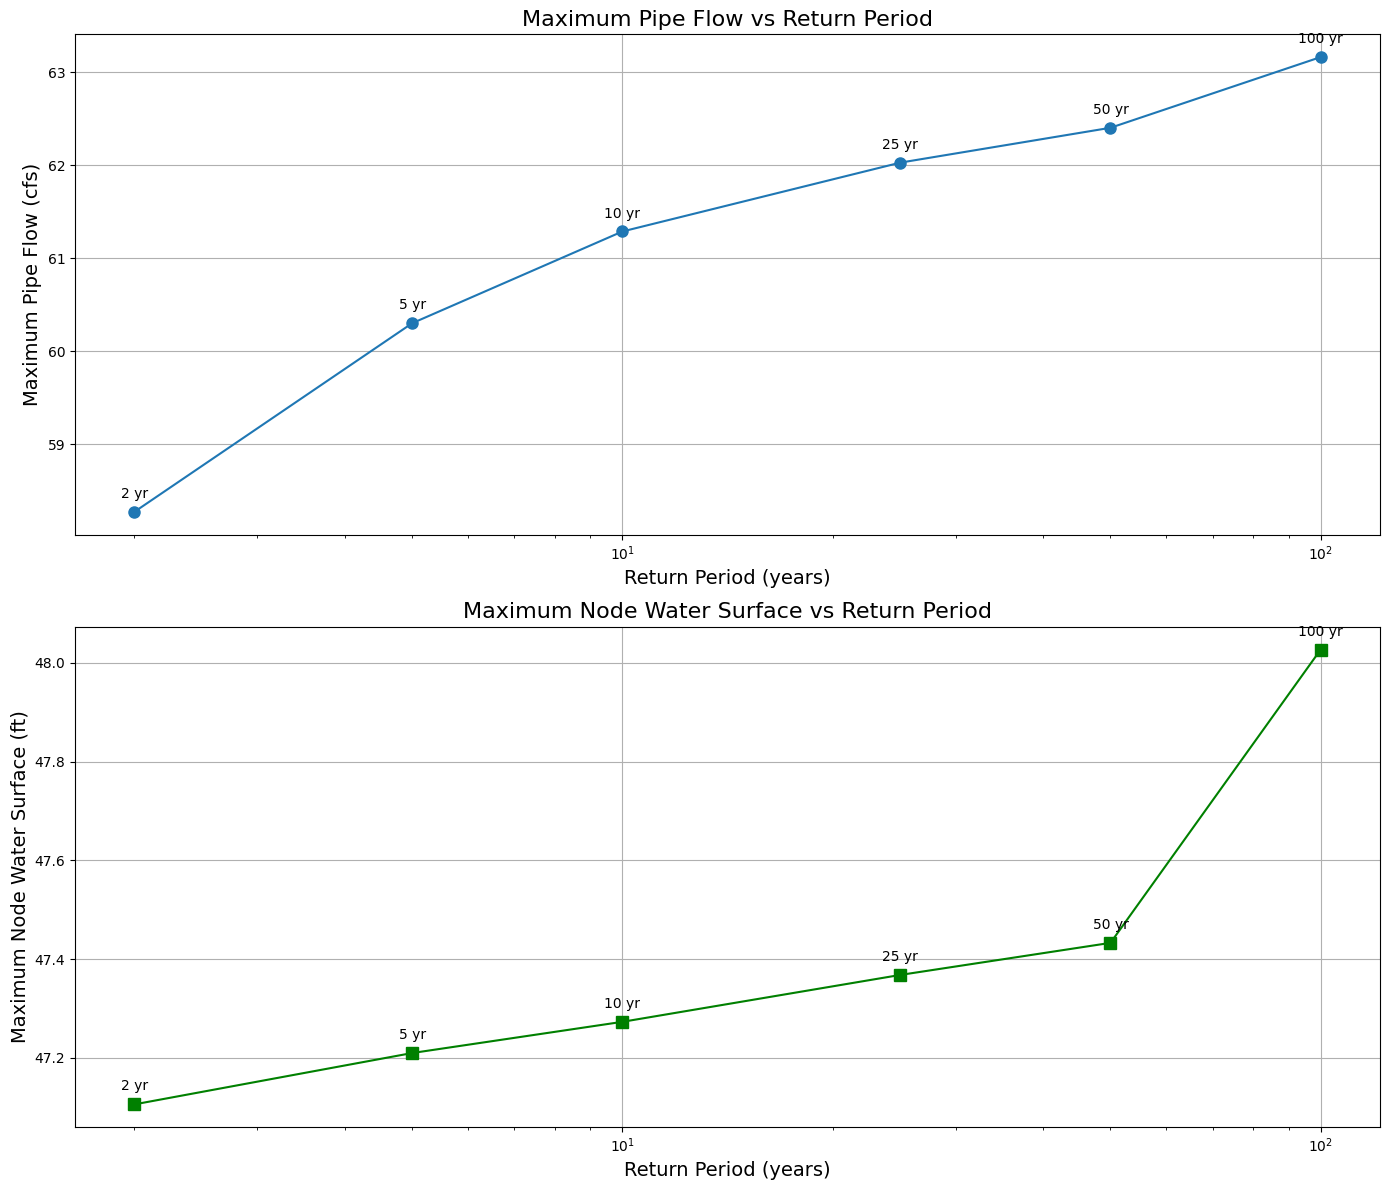

2025-04-10 05:13:55 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-04-10 05:13:55 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-04-10 05:13:55 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p03.hdf
2025-04-10 05:13:55 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p03.hdf
2025-04-10 05:13:55 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-04-10 05:13:55 - ras_commander.HdfPipe

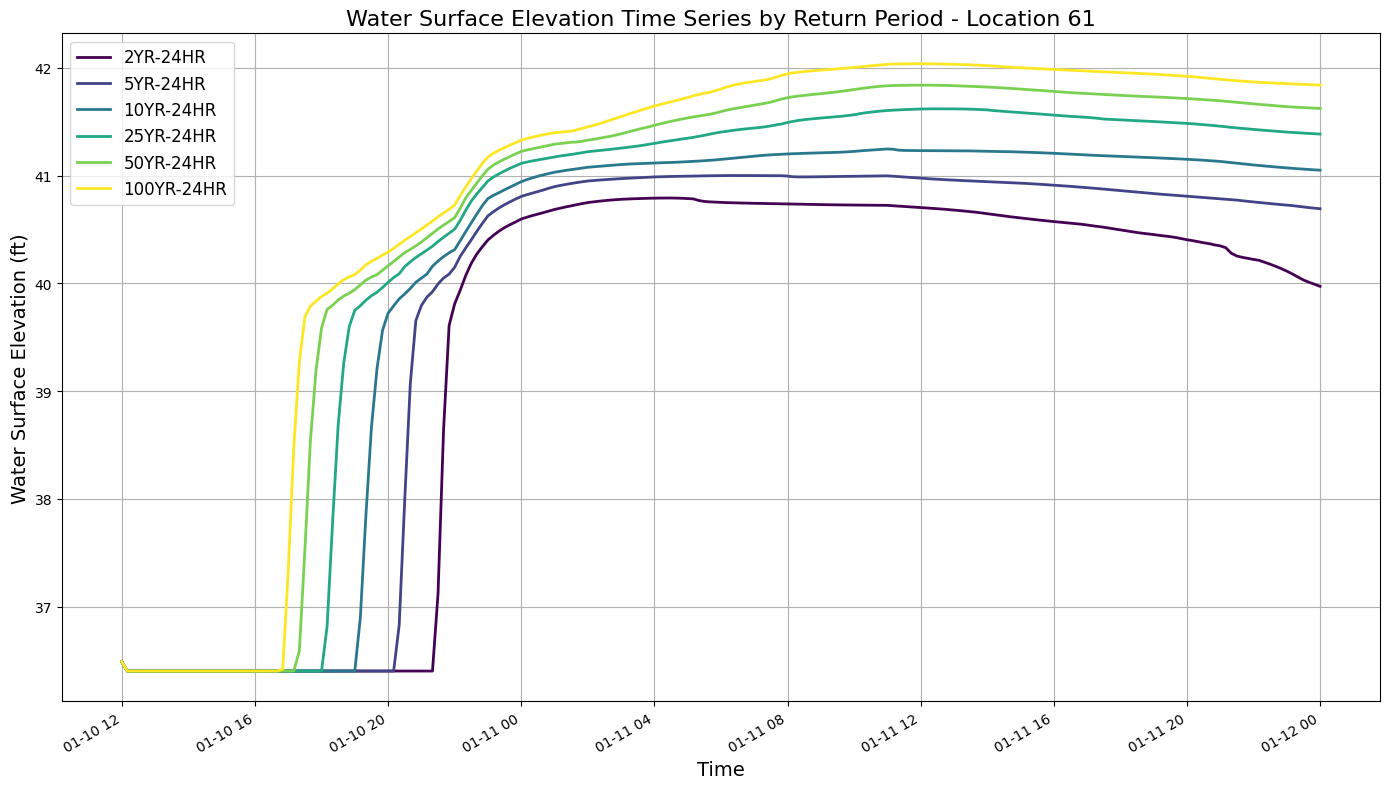

In [35]:
#---------------------------------------------------------------------
# Step 6: Plot the results
#---------------------------------------------------------------------
print("\nStep 6: Plotting the results...")

plot_results(analysis_df)

In [36]:


node_ws = HdfPipe.get_pipe_network_timeseries("04", variable="Nodes/Water Surface")




2025-04-10 05:13:56 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p04.hdf


In [37]:
node_ws

<xarray.DataArray 'Nodes/Water Surface' (time: 217, location: 133)> Size: 115kB
array([[26.98    , 25.79    , 28.87    , ..., 41.64    , 42.23    ,
        38.      ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       ...,
       [40.33194 , 40.154865, 40.496986, ..., 40.816566, 42.010223,
        40.519657],
       [40.32187 , 40.145065, 40.486317, ..., 40.8163  , 42.010044,
        40.508324],
       [40.311813, 40.13525 , 40.47572 , ..., 40.816044, 42.00987 ,
        40.49715 ]], shape=(217, 133), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 126 127 128 129 130 131 132
Attributes:
    units:     ft
    variable:  Nodes/Water Surface

In [38]:
pipe_flow_ds = HdfPipe.get_pipe_network_timeseries("04", variable="Pipes/Pipe Flow DS")

2025-04-10 05:13:56 - ras_commander.HdfPipe - INFO - Final validated HDF file path: d:\GitHub\ras-commander\examples\example_projects\Davis\compute_aep_parallel\DavisStormSystem.p04.hdf


In [39]:
pipe_flow_ds

<xarray.DataArray 'Pipes/Pipe Flow DS' (time: 217, location: 132)> Size: 115kB
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       ...,
       [ 5.1740509e+01,  2.2795265e+01,  5.1741089e+01, ...,
         1.0633533e-03,  5.7101989e-04,  1.2437085e-03],
       [ 5.1701267e+01,  2.2716499e+01,  5.1701866e+01, ...,
         1.0785812e-03,  5.5132189e-04,  1.2681987e-03],
       [ 5.1665817e+01,  2.2648956e+01,  5.1666412e+01, ...,
         1.0612740e-03,  5.3235044e-04,  1.2497420e-03]],
      shape=(217, 132), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 125 126 127 128 129 130 131
Attributes:
    units:     ft^3/s
    variable:  Pipes/Pipe Flow DS

## Conclusion

This notebook demonstrates a comprehensive workflow for automated AEP storm analysis using RAS-Commander. The key benefits of this approach include:

1. **Efficiency**: Automating repetitive tasks saves time and reduces errors
2. **Consistency**: Ensures consistent methodology across all return periods
3. **Parallel Execution**: Makes optimal use of computational resources
4. **Comprehensive Analysis**: Extracts and visualizes key metrics across return periods
5. **Reproducibility**: The entire workflow is documented and repeatable

This approach can be extended to include additional analyses, such as:

- Comparing different storm patterns (e.g., position of peak intensity)
- Analyzing climate change scenarios by adjusting precipitation depths
- Evaluating infrastructure improvements by comparing baseline and modified geometries
- Generating frequency curves for key hydraulic parameters

By leveraging the power of RAS-Commander, engineers can focus on interpreting results and making design decisions rather than managing model configurations.

# DEV NOTES: 

Need to add example of setting Start Time and End Time

Need to add function to library that will end-to-end model Atlas 14 AEP storms given an input lat/long, Return Interval and Duration, given a working geometry w/infiltration.  Running optional.

